In [103]:
#I have done this assignment 3 on my own as I was not able to find a team partner for the project. So i completed some tasks of 10-11 points out of 20
#Nishant Thakre 
#Roll No =200070051

In [104]:
#some refrences used in the assignment
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
#https://cvnote.ddlee.cc/2019/09/12/psnr-ssim-python

In [105]:
import cv2
import pywt
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from skimage import exposure
from math import log10, sqrt
from scipy.ndimage.filters import gaussian_filter
#importing all the libraries required for different parts of questions


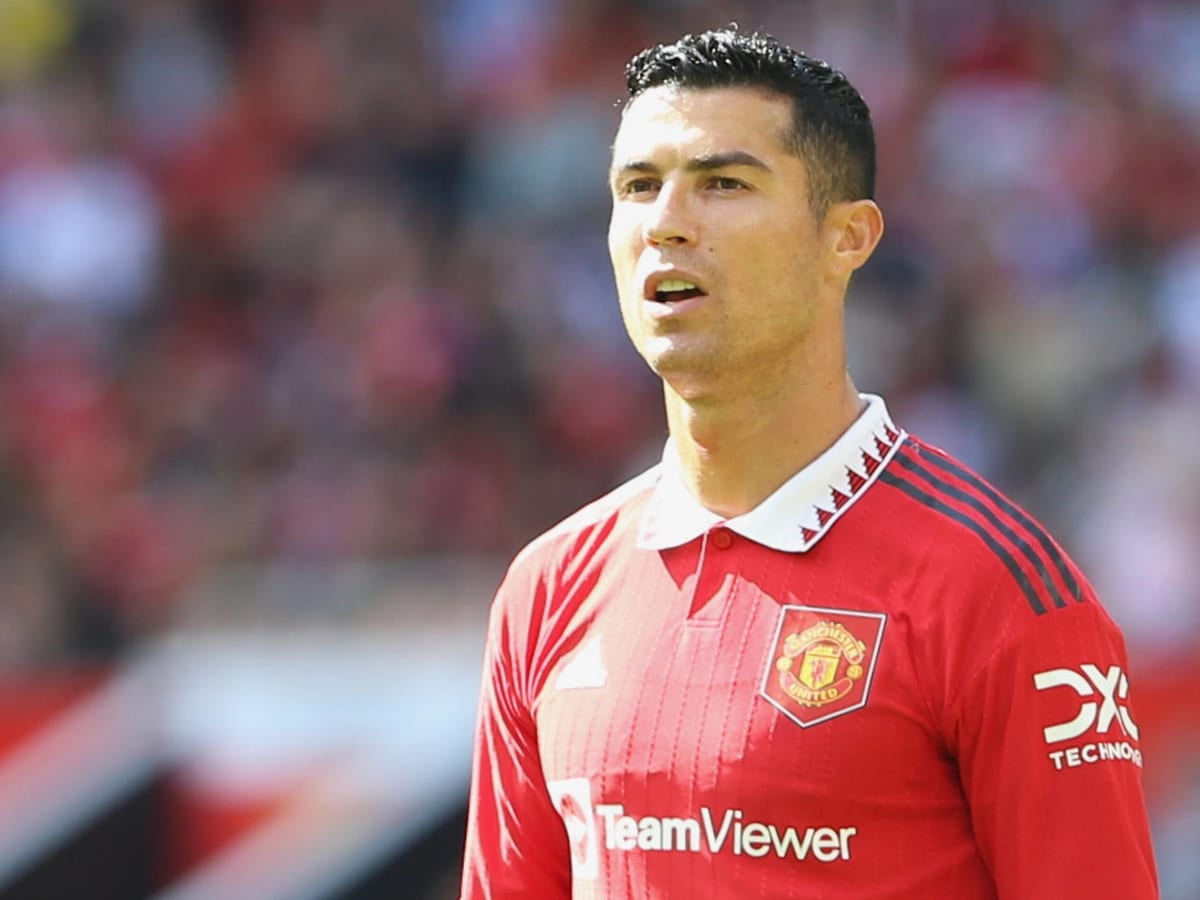

(900, 1200, 3)


In [106]:
# reading and displaying image i will be using in maximum part of the assignment
image=cv2.imread('Ronaldo.jpg', cv2.IMREAD_UNCHANGED) #reading image using open cv cv2.IMREAD_UNCHANGED used to avoid error (idea taken from stack overflow) 
cv2_imshow(image) #to display image
dimension=image.shape #to get its shape
print(dimension) # to print the shape

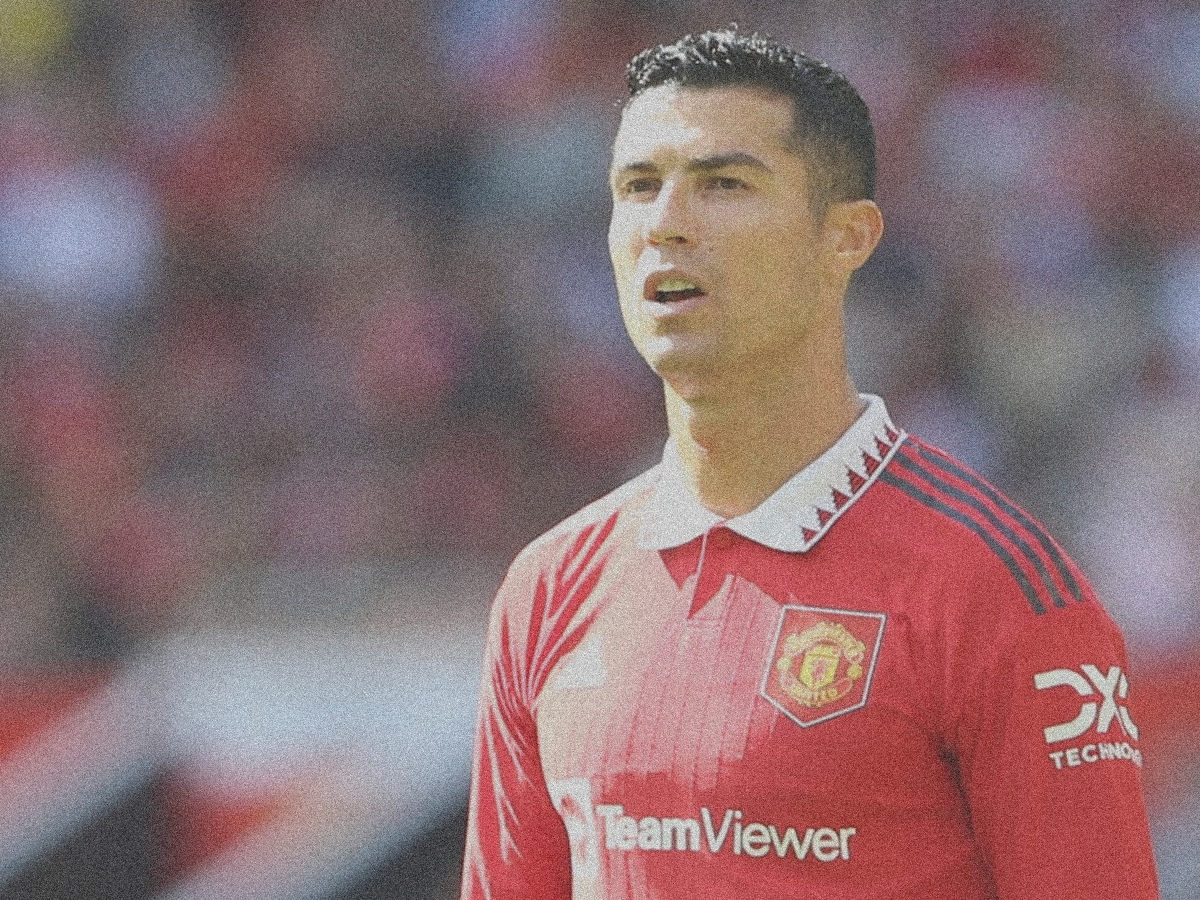

In [107]:
# Question 1 a
g1=image.copy()
row,col,x=g1.shape
mean = 0
var = 400
sigma = var ** 0.5
gaussian = np.random.normal(mean, sigma, (row,col)) # generating a gaussian noise
g1_withnoise=np.zeros((row,col,3),np.float32)
g1_withnoise[:, :, 0]=g1[:, :, 0]+gaussian # adding gaussian noise to rgb values separately
g1_withnoise[:, :, 1]=g1[:, :, 1]+gaussian
g1_withnoise[:, :, 2]=g1[:, :, 2]+gaussian
cv2.normalize(g1_withnoise,g1_withnoise, 0, 255, cv2.NORM_MINMAX, dtype=-1) #normalizing
g1_withnoise=g1_withnoise.astype(np.uint8)
cv2_imshow(g1_withnoise)
# we were able to observe grains(noise) after variance was a high value and >= 255
# refrence https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a

In [108]:
# Question 1 part b 
mse = np.mean((image - g1_withnoise ) ** 2) #calculation of mean square error
if(mse == 0):  # if mse is zero means it means that no noise is present in the signal. Therefore PSNR has no importance.
  psnr=100
else:
  max_pixel = 255.0
  psnr = 20 * log10(max_pixel / sqrt(mse)) #formula 
print(psnr)
  # refrence https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image

28.286584808408094


In [109]:
#Question 1 part c
#function for ssim mapping
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)) #formula
    return ssim_map.mean()

In [110]:
#Question 1 part c
def calculate_ssim(image, g1_withnoise):
  if not image.shape == g1_withnoise.shape:
          raise ValueError('Input images must have the same dimensions.')
  if image.ndim == 2:
      return ssim(image, g1_withnoise)
  elif image.ndim == 3:
      if image.shape[2] == 3:
          ssims = []
          for i in range(3):
              ssims.append(ssim(image, g1_withnoise))
          return np.array(ssims).mean()
      elif image.shape[2] == 1:
          return ssim(np.squeeze(image), np.squeeze(g1_withnoise))
  else:
      raise ValueError('Wrong input image dimensions.')

In [111]:
#Question 1 part c
calculate_ssim(image, g1_withnoise)

0.3363768021112222

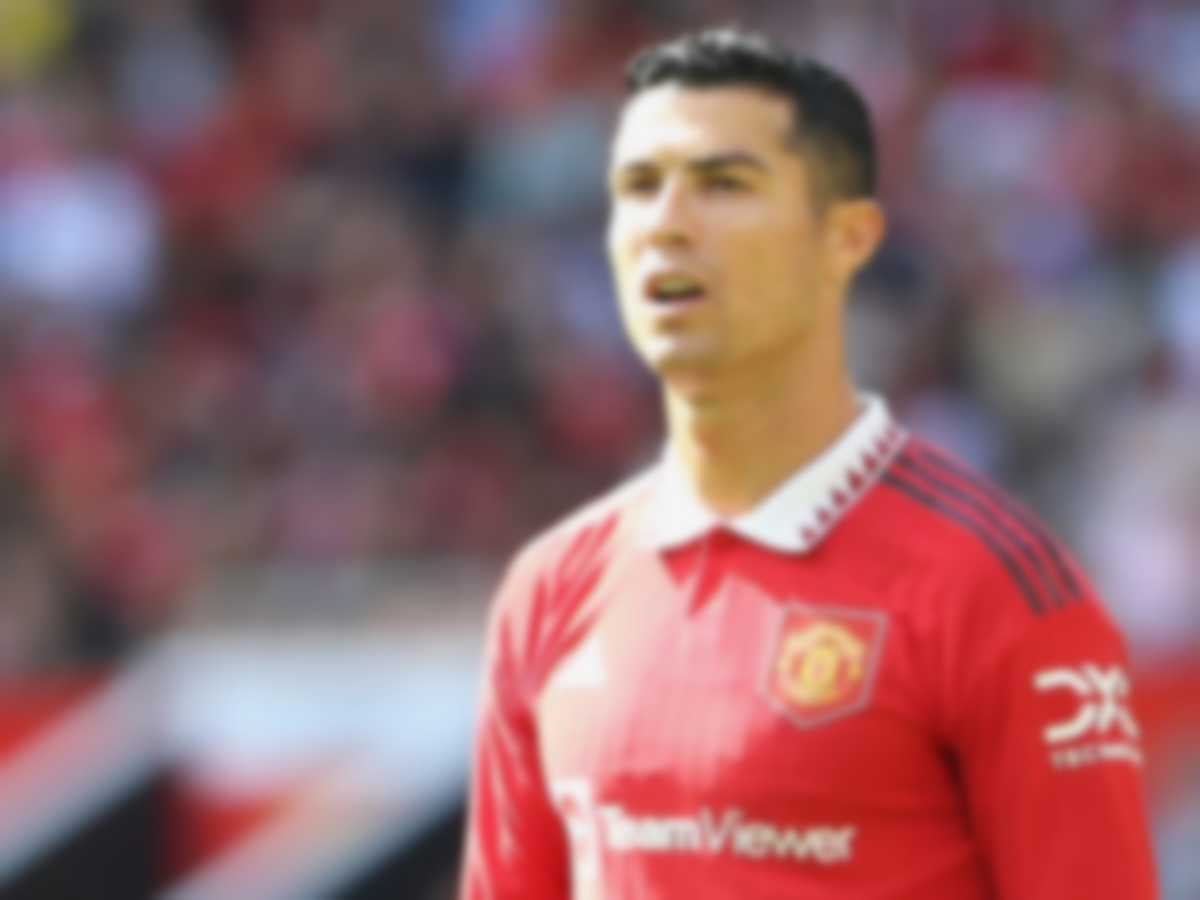

In [112]:
#Question 1 part d
x=np.zeros((row,col,3),np.float32)
x[:, :, 0]=gaussian_filter(image[:, :, 0], sigma=5)
#applying gaussian filter on image on rgb values separately
x[:, :, 1]=gaussian_filter(image[:, :, 1], sigma=5)
x[:, :, 2]=gaussian_filter(image[:, :, 2], sigma=5)
cv2_imshow(x)
#refrence https://stackoverflow.com/questions/29920114/how-to-gauss-filter-blur-a-floating-point-numpy-array

In [113]:
#Question 2 part a
def madev(d, axis=None): #funaction for mean absolute deviation
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)
def wavelet_denoising(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per") # calculation of wavelet transform
    sigma = (1/0.6745) * madev(coeff[-level]) #sigma calcualtion
    uthresh = sigma * np.sqrt(2 * np.log(len(x))) #threshold calculation
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:]) #  Hard thresholding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold
    return pywt.waverec(coeff, wavelet, mode='per') #claculating inverse wavelet tranform
# refrnece https://www.kaggle.com/code/theoviel/denoising-with-direct-wavelet-transform#Discrete-Wavelet-Transform-(dwt)-denoising

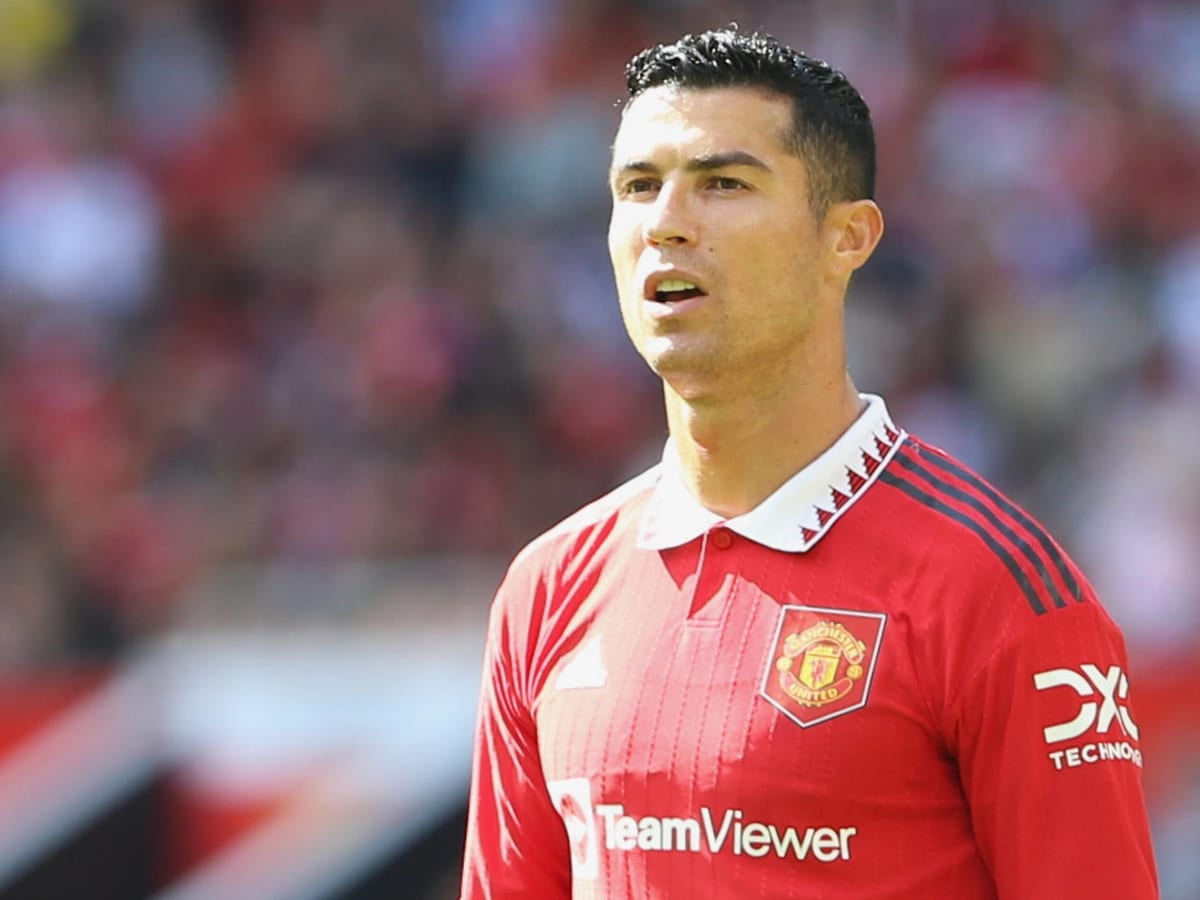

In [114]:
#Question 2 part a
y=wavelet_denoising(image, wavelet='db4', level=1)
cv2_imshow(y)

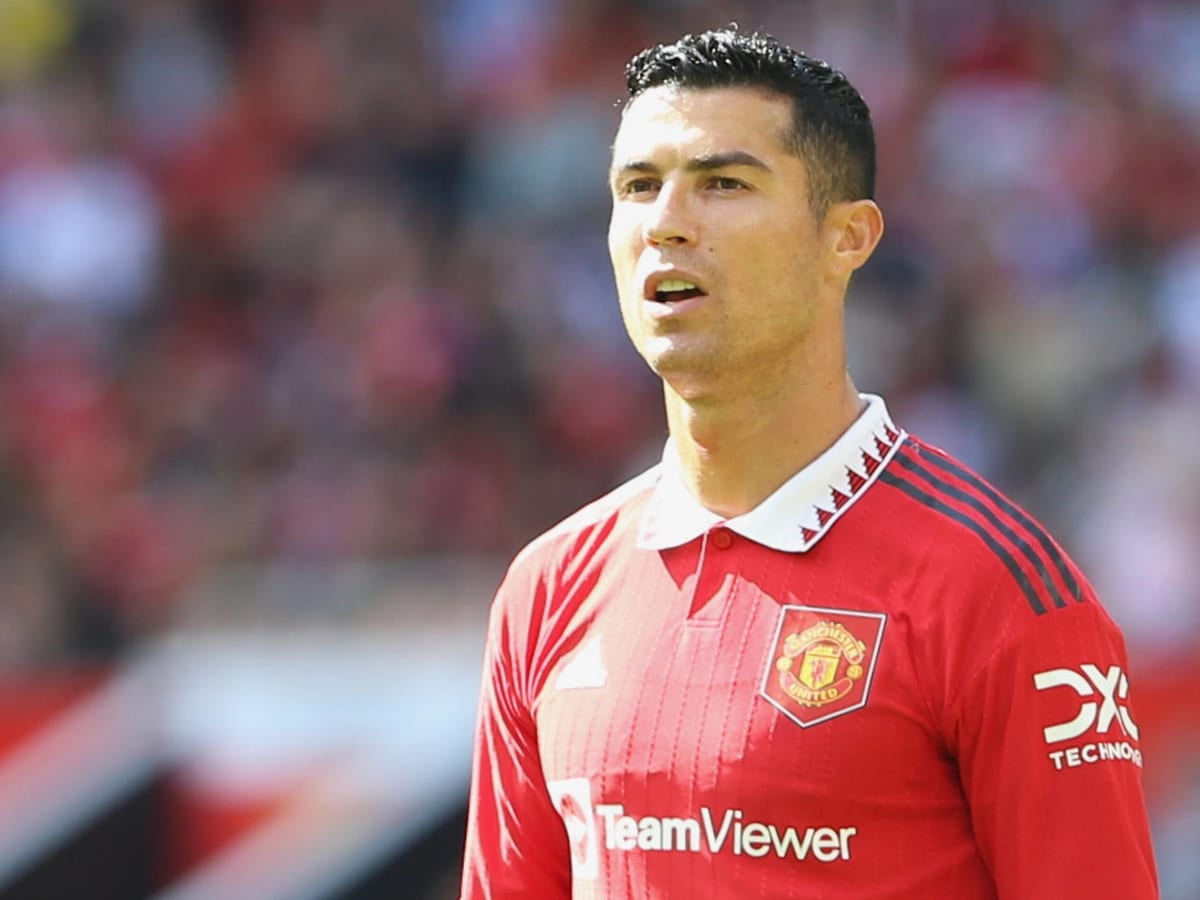

In [115]:
#question 2 part b soft thresholding 
def wavelet_denoising(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')
y=wavelet_denoising(image, wavelet='db4', level=1)
cv2_imshow(y)

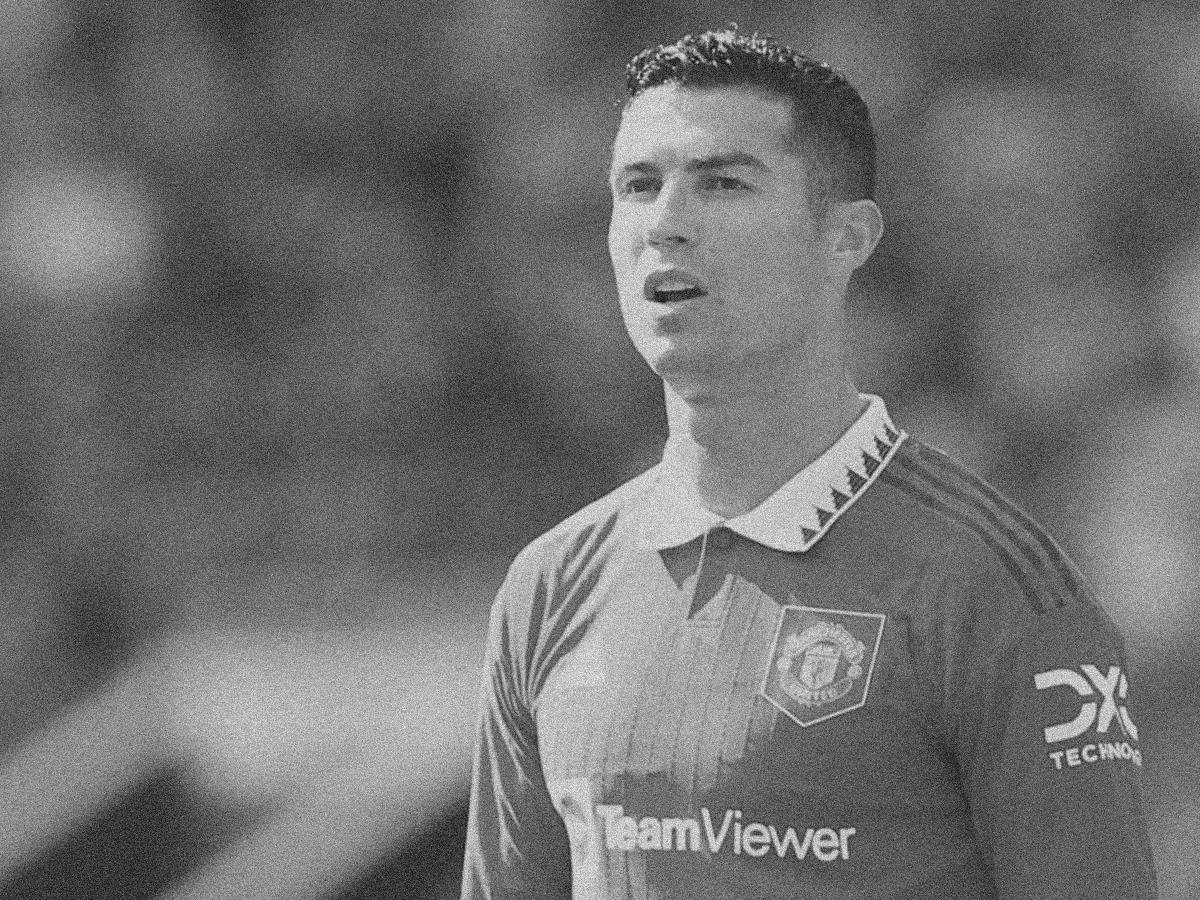

In [116]:
# for Q2 part c i am taking grayscale image and adding noise to it as done in part 1
gray=cv2.imread('Ronaldo.jpg',0)
gi1=gray.copy()
row,col=gi1.shape
mean = 0
sigma =20
gaussian = np.random.normal(mean, sigma, (row,col))
gi_withnoise=np.zeros((row,col),np.float32)
gi_withnoise=gi1+gaussian
cv2.normalize(gi_withnoise,gi_withnoise, 0, 255, cv2.NORM_MINMAX, dtype=-1)
gi_withnoise=gi_withnoise.astype(np.uint8)
gray2=gi_withnoise
cv2_imshow(gray2)

In [117]:
#Question 2 part c 
#following function is implemented after reading the paper
def chen_et_al(noisyimg,n,sigma):
  lambdaa=sigma*(np.sqrt(4*np.log(n))) #defining lamda as given in the paper
  CA,(CH,CV,CD)= pywt.dwt2(noisyimg,'haar') #extracting coeficients 
  r=np.shape(CH)[0]
  c=np.shape(CH)[1]
  x,y,z=CH.copy(),CV.copy(),CD.copy()
  #for padding
  CH1=np.pad(x,1)
  CV1=np.pad(y,1)
  CD1=np.pad(z,1)
  SH=np.zeros([r,c])
  BH=np.zeros([r,c])
  SV=np.zeros([r,c])
  BV=np.zeros([r,c])
  SD=np.zeros([r,c])
  BD=np.zeros([r,c])
  for i in range(0,r):
    for j in range(0,c):
      SH[i][j]=CH1[i][j]**2 + CH1[i][j+1]**2 + CH1[i][j+2]**2 + CH1[i+1][j]**2 + CH1[i+1][j+1]**2 + CH1[i+1][j+2]**2 + CH1[i+2][j]**2 + CH1[i+2][j+1]**2 + CH1[i+2][j+2]**2
      SV[i][j]=CV1[i][j]**2 +CV1[i][j+1]**2+CV1[i][j+2]**2+CV1[i+1][j]**2+CV1[i+1][j+1]**2+CV1[i+1][j+2]**2+CV1[i+2][j]**2+CV1[i+2][j+1]**2+CV1[i+2][j+2]**2
      SD[i][j]=CD1[i][j]**2+CD1[i][j+1]**2+CD1[i][j+2]**2+CD1[i+1][j]**2+CD1[i+1][j+1]**2+CD1[i+1][j+2]**2+CD1[i+2][j]**2+CD1[i+2][j+1]**2+CD1[i+2][j+2]**2
      BH[i][j]=1-((lambdaa**2)/(SH[i][j])) #as given in paper
      BV[i][j]=1-((lambdaa**2)/(SV[i][j]))
      BD[i][j]=1-((lambdaa**2)/(SD[i][j]))
      if(BH[i][j]<0):
        BH[i][j]=0
      if(BV[i][j]<0):
        BV[i][j]=0
      if(BD[i][j]<0):
        BD[i][j]=0
  CH*=BH
  CV*=BV
  CD*=BD
  output=pywt.idwt2((CA,(CH,CV,CD)),'haar') #inverse transform
  cv2_imshow(output)

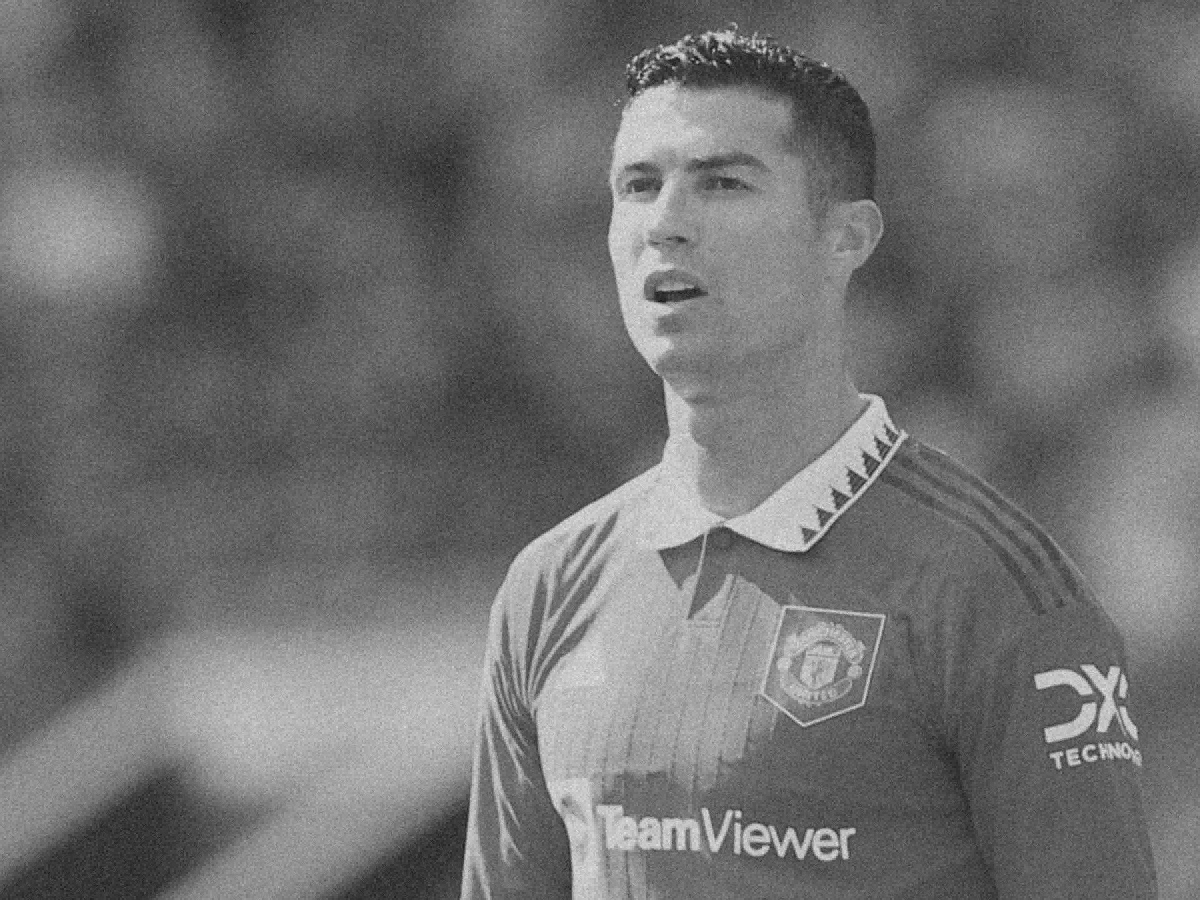

In [118]:
#Question 2 part c
chen_et_al(gray2,3,20) #passing noise image with n=3 and sigma=20

In [128]:
#function that adds gaussian noise to image same as Q1a will be used in plotting of psnr and ssim
def noisy(var,image):
  g1=image.copy()
  row,col,lkm=g1.shape
  mean = 0
  sigma = var ** 0.5
  gaussian = np.random.normal(mean, sigma, (row,col))
  g1_withnoise=np.zeros((row,col,3),np.float32)
  g1_withnoise[:, :, 0]=g1[:, :, 0]+gaussian
  g1_withnoise[:, :, 1]=g1[:, :, 1]+gaussian
  g1_withnoise[:, :, 2]=g1[:, :, 2]+gaussian
  cv2.normalize(g1_withnoise,g1_withnoise, 0, 255, cv2.NORM_MINMAX, dtype=-1)
  g1_withnoise=g1_withnoise.astype(np.uint8)
  return g1_withnoise

In [129]:
#function that calculates psnr same as Q1b will be used in plotting of psnr
def PSNR(compressed, image):
    mse = np.mean((image - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
#Question 3 part a
def psnrvar(var,image):
  noisyimg=noisy(var, image) #add noise to image with given varinace
  return PSNR(noisyimg, image) #return psnr value

In [138]:
#Question 3 part a
x =np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
y=np.zeros(10)
for i in range(10):
  y[i]=psnrvar(x[i],image)

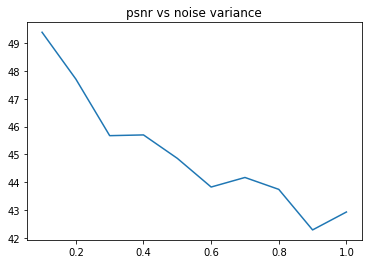

In [139]:
plt.title('psnr vs noise variance')
plt.plot(x, y)

In [123]:
#Q3 part a 
def ssimvar(var,image):
  noisedimg=noisy(var, image) #adds noise to given varinace
  return calculate_ssim(image,noisedimg) #calculates ssim

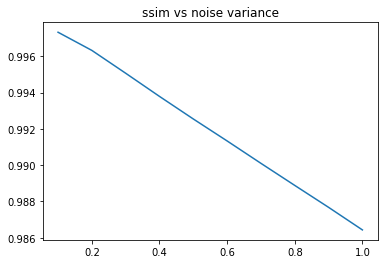

In [144]:
#question 3 part a
a=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
b=np.zeros(10)
for i in range(10):
  b[i]=ssimvar(a[i],image)
plt.title('ssim vs noise variance')
plt.plot(a, b)


In [125]:
#question 3 part b
def gaussfilter(var,image): # function to apply gaussian filter same as Q1 part d
  a=var**0.5
  x=np.zeros((row,col,3),np.float32)
  x[:, :, 0]=gaussian_filter(image[:, :, 0], sigma=a)
  x[:, :, 1]=gaussian_filter(image[:, :, 1], sigma=a)
  x[:, :, 2]=gaussian_filter(image[:, :, 2], sigma=a)
  return x
def psnrvar3b(var,image):
  noisyimg=gaussfilter(var, image) # applies filter with given variance
  return PSNR(noisyimg, image) # calculates psnr with original image
#similarly for ssim
def ssimvar3b(var,image):
  noisedimg=gaussfilter(var, image)
  return calculate_ssim(image,noisedimg)

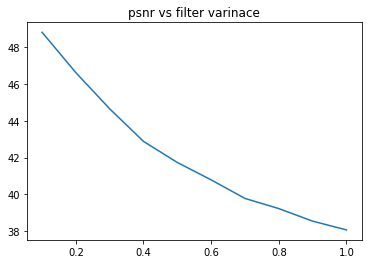

In [142]:
#question 3 part b
a=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
b=np.zeros(10)
for i in range(10):
  b[i]=psnrvar3b(a[i],image)
plt.title('psnr vs filter varinace')
plt.plot(a, b)

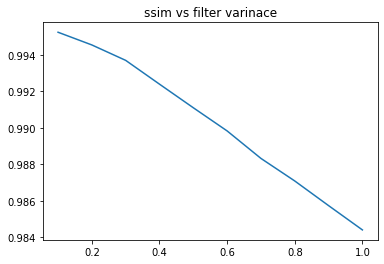

In [143]:
#question 3 part b
a=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
b=np.zeros(10)
for i in range(10):
  b[i]=ssimvar3b(a[i],image)
plt.title('ssim vs filter varinace')
plt.plot(a, b)